In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

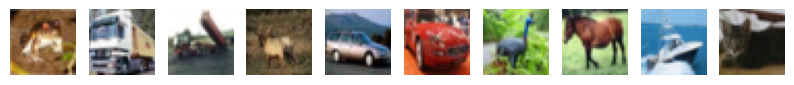

In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [5]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,514
Trainable params: 14,514
Non-traina

In [7]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.087


#### Train model with checkpoints

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# Create Tensorflow checkpoint object
checkpoint_path = "model_checkpoints/checkpoint"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            frequency = 'epoch',
                            save_weights_only = True,
                            verbose = 1)

In [10]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch
model.fit(x = x_train,
         y = y_train,
         epochs = 3,
         callbacks = [checkpoint])

Epoch 1/3
309/313 [============================>.] - ETA: 0s - loss: 2.0178 - accuracy: 0.2521
Epoch 1: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 13s 38ms/step - loss: 2.0147 - accuracy: 0.2538
Epoch 2/3
313/313 [==============================] - ETA: 0s - loss: 1.6065 - accuracy: 0.4174
Epoch 2: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 11s 35ms/step - loss: 1.6065 - accuracy: 0.4174
Epoch 3/3
311/313 [============================>.] - ETA: 0s - loss: 1.4679 - accuracy: 0.4667
Epoch 3: saving model to model_checkpoints\checkpoint
313/313 [==============================] - 10s 32ms/step - loss: 1.4676 - accuracy: 0.4668


In [11]:
# Have a look at what the checkpoint creates
! ls -lh model_checkpoints

total 181K
-rw-r--r-- 1 Trung None   77 Apr 29 09:08 checkpoint
-rw-r--r-- 1 Trung None 174K Apr 29 09:08 checkpoint.data-00000-of-00001
-rw-r--r-- 1 Trung None 2.0K Apr 29 09:08 checkpoint.index


In [12]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.481


#### Create new model, load weights

In [13]:
# Create a new instance of the (initialised) model, accuracy around 10% again
model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.110


In [14]:
# Load weights -- accuracy is the same as the trained model
model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.481


#### Clear directory

In [15]:
! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
# Create Tensorflow checkpoint object with epoch and batch details
checkpoint_5000_path = "model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:04d}"
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                 save_weights_only= True,
                                 save_freq= 1000,
                                 verbose=1)

In [18]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x = x_train,
         y = y_train,
         epochs=3,
         validation_data = (x_test, y_test),
         batch_size = 10,
         callbacks = [checkpoint_5000])

Epoch 1/3
 999/1000 [============================>.] - ETA: 0s - loss: 1.8005 - accuracy: 0.3454
Epoch 1: saving model to model_checkpoints_5000\checkpoint_01_1000
1000/1000 [==============================] - 43s 42ms/step - loss: 1.8010 - accuracy: 0.3453 - val_loss: 1.5116 - val_accuracy: 0.4740
Epoch 2/3
 996/1000 [============================>.] - ETA: 0s - loss: 1.4417 - accuracy: 0.4877
Epoch 2: saving model to model_checkpoints_5000\checkpoint_02_1000
1000/1000 [==============================] - 39s 39ms/step - loss: 1.4417 - accuracy: 0.4878 - val_loss: 1.3886 - val_accuracy: 0.5140
Epoch 3/3
 998/1000 [============================>.] - ETA: 0s - loss: 1.3303 - accuracy: 0.5285
Epoch 3: saving model to model_checkpoints_5000\checkpoint_03_1000
1000/1000 [==============================] - 44s 44ms/step - loss: 1.3306 - accuracy: 0.5283 - val_loss: 1.3578 - val_accuracy: 0.4970


In [19]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints_5000

total 541K
-rw-r--r-- 1 Trung None   93 Apr 29 09:10 checkpoint
-rw-r--r-- 1 Trung None 174K Apr 29 09:09 checkpoint_01_1000.data-00000-of-00001
-rw-r--r-- 1 Trung None 2.0K Apr 29 09:09 checkpoint_01_1000.index
-rw-r--r-- 1 Trung None 174K Apr 29 09:10 checkpoint_02_1000.data-00000-of-00001
-rw-r--r-- 1 Trung None 2.0K Apr 29 09:10 checkpoint_02_1000.index
-rw-r--r-- 1 Trung None 174K Apr 29 09:10 checkpoint_03_1000.data-00000-of-00001
-rw-r--r-- 1 Trung None 2.0K Apr 29 09:10 checkpoint_03_1000.index


#### Work with model saving criteria

In [20]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [21]:
# Create a new instance of untrained model
model = get_new_model()


In [22]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                 save_weights_only= True,
                                 save_freq= 'epoch',
                                 monitor='val_accuracy',
                                 save_best_only= True,
                                 verbose = 1)

In [23]:
# Fit the model and save only the weights with the highest validation accuracy
history = model.fit(x = x_train,
                   y = y_train,
                   epochs = 50,
                   validation_data= (x_test, y_test),
                   batch_size= 10,
                   callbacks= [checkpoint_best],
                   verbose= 0)


Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to model_checkpoints_best\checkpoint

Epoch 2: val_accuracy did not improve from 0.10000

Epoch 3: val_accuracy did not improve from 0.10000

Epoch 4: val_accuracy did not improve from 0.10000

Epoch 5: val_accuracy did not improve from 0.10000

Epoch 6: val_accuracy did not improve from 0.10000

Epoch 7: val_accuracy did not improve from 0.10000

Epoch 8: val_accuracy did not improve from 0.10000

Epoch 9: val_accuracy did not improve from 0.10000

Epoch 10: val_accuracy did not improve from 0.10000

Epoch 11: val_accuracy did not improve from 0.10000

Epoch 12: val_accuracy improved from 0.10000 to 0.17000, saving model to model_checkpoints_best\checkpoint

Epoch 13: val_accuracy did not improve from 0.17000

Epoch 14: val_accuracy did not improve from 0.17000

Epoch 15: val_accuracy did not improve from 0.17000

Epoch 16: val_accuracy did not improve from 0.17000

Epoch 17: val_accuracy improved from 0.17000 to 0.210

<AxesSubplot: >

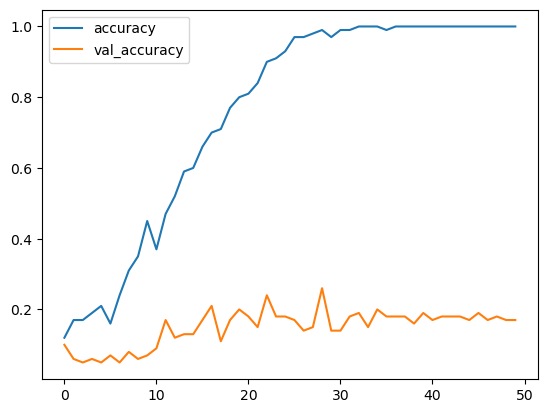

In [24]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [25]:
# Inspect the checkpoint directory
! ls -lh model_checkpoints_best


total 181K
-rw-r--r-- 1 Trung None   77 Apr 29 09:11 checkpoint
-rw-r--r-- 1 Trung None 174K Apr 29 09:11 checkpoint.data-00000-of-00001
-rw-r--r-- 1 Trung None 2.0K Apr 29 09:11 checkpoint.index


In [26]:
# Create a new model with the saved weights
new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.260


#### Clear directory

In [27]:
! rm -r model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only= False,
                            frequency = 'epoch',
                            verbose = 1)

In [30]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x = x_train,
         y = y_train,
         epochs=3,
         callbacks=[checkpoint])

Epoch 1/3
3/4 [=====================>........] - ETA: 0s - loss: 2.3161 - accuracy: 0.0938
Epoch 1: saving model to model_checkpoints


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


4/4 [==============================] - 2s 406ms/step - loss: 2.3144 - accuracy: 0.1000
Epoch 2/3
3/4 [=====================>........] - ETA: 0s - loss: 2.2785 - accuracy: 0.1146
Epoch 2: saving model to model_checkpoints


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


4/4 [==============================] - 1s 359ms/step - loss: 2.2818 - accuracy: 0.1100
Epoch 3/3
4/4 [==============================] - ETA: 0s - loss: 2.2687 - accuracy: 0.1100
Epoch 3: saving model to model_checkpoints


INFO:tensorflow:Assets written to: model_checkpoints\assets


INFO:tensorflow:Assets written to: model_checkpoints\assets


4/4 [==============================] - 1s 307ms/step - loss: 2.2687 - accuracy: 0.1100


#### Inspect what the checkpoint has created

In [31]:
# Have a look at what the checkpoint creates
! ls -lh model_checkpoints

total 144K
drwxr-xr-x 1 Trung None    0 Apr 29 09:11 assets
-rw-r--r-- 1 Trung None  15K Apr 29 09:11 keras_metadata.pb
-rw-r--r-- 1 Trung None 123K Apr 29 09:11 saved_model.pb
drwxr-xr-x 1 Trung None    0 Apr 29 09:11 variables


In [32]:
# Enter variables directory
! ls -lh model_checkpoints/variables

total 184K
-rw-r--r-- 1 Trung None 179K Apr 29 09:11 variables.data-00000-of-00001
-rw-r--r-- 1 Trung None 2.2K Apr 29 09:11 variables.index


In [33]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)

accuracy: 0.070


#### Create new model from scratch

In [34]:
# Delete model
del model

In [35]:
from tensorflow.keras.models import load_model

In [36]:
# Reload model from scratch
model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.070


#### Use the .h5 format to save model

In [37]:
# Save the model in .h5 format
model.save("my_model.h5")

In [38]:
# Inspect .h5 file
! ls -lh my_model.h5

-rw-r--r-- 1 Trung None 78K Apr 29 09:11 my_model.h5


In [39]:
# Delete model
del model

In [40]:
# Reload model from scratch
model = load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.070


#### Clear directory

In [41]:
! rm -r model_checkpoints
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model using the Keras API.

In [42]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')

#### Import and preprocess 3 sample images

In [43]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [44]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [45]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

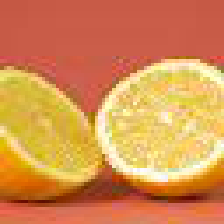

In [46]:
# Display image
lemon_img

In [47]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)

35363/35363 [==============================] - 0s 3us/step


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151336
4,ladle,0.040088
5,spotlight,0.029197


##### Image 2: viaduct

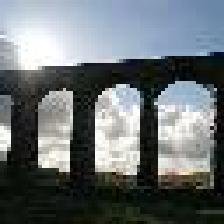

In [53]:
# Display image
viaduct_img

In [54]:
# Display top 5 predictions
get_top_5_predictions(viaduct_img)

1/1 [==============================] - 0s 220ms/step


,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.088231
5,fire_screen,0.020675


##### Image 3: water tower

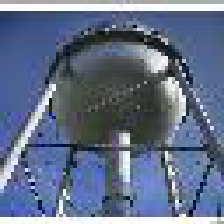

In [55]:
# Display image
water_tower_img

In [56]:
# Display top 5 predictions
get_top_5_predictions(water_tower_img)

1/1 [==============================] - 0s 209ms/step


,prediction,probability
1,solar_dish,0.384682
2,ladle,0.196178
3,planetarium,0.116683
4,strainer,0.04999
5,jigsaw_puzzle,0.021947


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model from TensorFlow Hub.

In [67]:
import tensorflow_hub as hub

In [68]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])

#### Use MobileNet model to classify images

In [79]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [80]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("water_tower.jpg", target_size=(160, 160))

In [85]:
# Read in categories text file

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
categories = np.array(open(labels_path).read().splitlines())

In [86]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

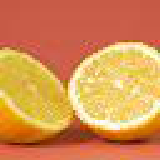

In [87]:
lemon_img

In [88]:
get_top_5_predictions(lemon_img)

1/1 [==============================] - 0s 32ms/step


,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

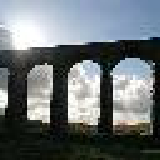

In [89]:
viaduct_img

In [90]:
get_top_5_predictions(viaduct_img)

1/1 [==============================] - 0s 33ms/step


,prediction
1,viaduct
2,pier
3,dam
4,prison
5,solar dish


##### Image 3: water tower

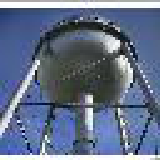

In [91]:
water_tower_img

In [92]:
get_top_5_predictions(water_tower_img)

1/1 [==============================] - 0s 33ms/step


,prediction
1,solar dish
2,water tower
3,aircraft carrier
4,jigsaw puzzle
5,oxygen mask
